<h1> Setting up </h1>

In [1]:
pip install pydicom pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.3 MB/s eta 0:00:00


In [2]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

<h1> Reading in the patient's DICOM files and viewing it </h1>

Note: the authors have limited neurology, computer science, and cancer biology knowledge. They aimed to automate this across all patients, however, the script could not properly identify the tumor. Without a radiologist or a specialist in neurology, their approach was:


1.   Load in all DICOM files and view each coronally
2.   Manually select which DICOM file has the 'best' region of interest
3.   Jot down the name of the file in an external Google Sheets

In [ ]:
path = '/content/drive/MyDrive/Hackathon/images/Filtered Patients/Burdenko-GBM-006/09-13-2004-NA-Radiotherapy planning 00-96243/10.000000-MR0T2FLAIR-21870/'

With the code above, the authors manually changed the path each time.

For example, 'Burdenko-GBM-004/09-05-2004-NA-Radiotherapy planning 00-82214/11.000000-MR0T2FLAIR-99492' would be copy and pasted after '.../Filtered Patients/'

In [ ]:
def load_dicom_volume_as_numpy(dicom_path):
    '''reads DICOM files in, then sorts based on image position, and creates a pixel array for each file. pixel arrays are then stacked to create a volume.'''
    dicom_files = []
    pixel_arrays = []
    # sort all files in directory
    all_files = sorted(os.listdir(dicom_path))

    # reads in DICOM files and adds it to dicom_files list
    for f in all_files:
      dicom_file = pydicom.dcmread(os.path.join(dicom_path, f))
      dicom_files.append(dicom_file)

    # sorts based on ImagePositionPatient[2] tag
    def sort_key(dicom):
      return float(dicom.ImagePositionPatient[2]) # this is the z-coordinate - used to order slices in a 3D image
    dicom_files.sort(key=sort_key)

    # giving each DICOM file a pixel array and adding that array to pixel_arrays list
    for s in dicom_files:
      pixel_arrays.append(s.pixel_arrays)

    # stacking pixel arrays to create a volume
    volume = np.stack(pixel_arrays)

    return volume, dicom_files


def visualize_coronal_slices(volume, dicom_files, num_columns=5):
    num_files = len(dicom_files)
    num_rows = (num_files + num_columns - 1) // num_columns

    # make a figure and axis for each file
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows*4))

    for i, dicom_file in enumerate(dicom_files):
        row = i // num_columns
        col = i % num_columns
        slice_index = int(dicom_file.InstanceNumber)
        coronal_slice = volume[:, slice_index, :].T # transpose to coronal

        # displaying
        if num_rows > 1:
          ax = axes[row,col]
        else:
          ax = axes[col]
        ax.imshow(coronal_slice, cmap = 'gray')
        ax.set_title(os.path.basename(dicom_file.filename))
        ax.axis('off')

    # making everything 1D and hiding unused subplots
    axes_flat = axes.flatten() if num_rows > 1 else [axes]
    for j in range(len(axes_flat)):
        if j >= num_files:
            axes_flat[j].set_visible(False)
    plt.tight_layout()
    plt.show()




dicom_folder_path = path
volume, dicom_files = load_dicom_volume_as_numpy(dicom_folder_path)
visualize_coronal_slices(volume, dicom_files)


Output hidden; open in https://colab.research.google.com to view.

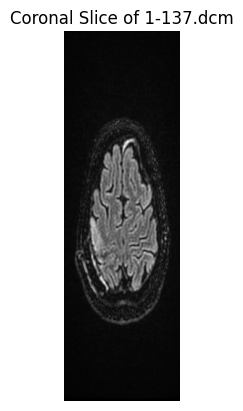

In [ ]:

selected_filename = "1-137.dcm"
coronal_slice = None

# looking for DICOM file
for dicom_file in dicom_files:
    if os.path.basename(dicom_file.filename) == selected_filename:
        slice_index = int(dicom_file.InstanceNumber) - 1  # getting index for coronal slice
        coronal_slice = volume[:, slice_index, :].T # using slice index to get coronal slice
        break

# checking and displaying coronal slice
if coronal_slice is not None:
    plt.imshow(coronal_slice, cmap='gray')
    plt.axis('off')
    plt.title(f"Coronal Slice of {selected_filename}")
    plt.show()
else:
    print(f"{selected_filename} not found")

<h1> Creating a mask for the slice to get the Region of Interest (ROI) </h1>

Once a DICOM file was selected:


1.   Coronal slice was normalized and converted to grayscale
2.   Image gets blurred/smoothed, its contrast adjusted, and made into a CLAHE object
3.   CLAHE object was thresholded, morphed, and contoured
4.   ROI was contoured and a binary mask was created from it
5.   Non-zero pixels were counted for the area of the tumor


Currently unsure of the pixel to metric system conversion for tumors









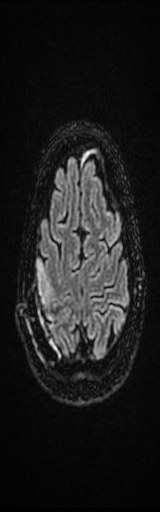

In [ ]:
coronal_slice_normalized = ((coronal_slice - np.min(coronal_slice)) / (np.max(coronal_slice) - np.min(coronal_slice))) * 255
coronal_slice_uint8 = coronal_slice_normalized.astype('uint8')
cv2_imshow(coronal_slice_uint8)
image = cv2.imread('coronal_slice.png', cv2.IMREAD_GRAYSCALE)

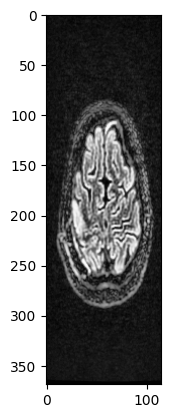

In [ ]:
blurred_image = cv2.GaussianBlur(image, (1,1), 0)
equalized_image = cv2.equalizeHist(blurred_image)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
clahe_image = clahe.apply(blurred_image)
plt.imshow(clahe_image, 'gray')

In [ ]:
# trying different threshold values manually
for i in range(0, 255, 10):
    clahe_image, binary_image = cv2.threshold(blurred_image, i, 255, cv2.THRESH_BINARY)
    plt.imshow(binary_image, cmap='gray')
    plt.title(f'Threshold at {i}')
    plt.show()

# write down thereshold here
# threshold at 130

In [ ]:
# replace threshold value below
clahe_image, binary_image = cv2.threshold(image, 130, 255, cv2.THRESH_BINARY)

kernel = np.ones((5,5), np.uint8)

opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

contours, clahe_image = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.copy(image)
cv2.drawContours(contour_image, contours, -1, (0,255,0), 3)

array([[2, 2, 2, ..., 5, 4, 4],
       [5, 4, 5, ..., 6, 5, 4],
       [5, 4, 4, ..., 5, 5, 5],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

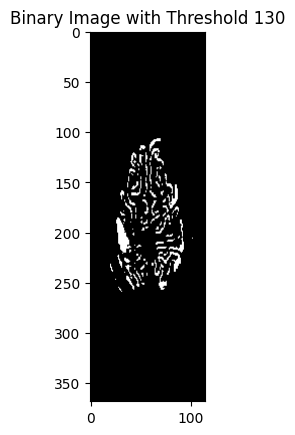

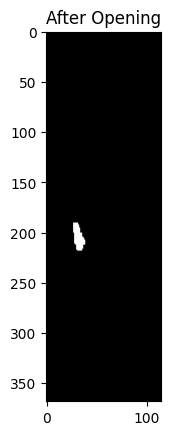

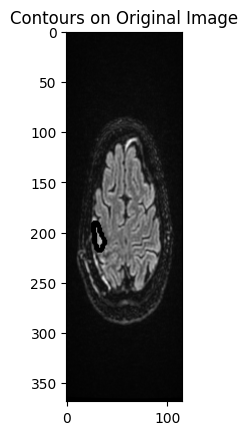

In [ ]:
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image with Threshold 130')
plt.show()

plt.imshow(opening, cmap='gray')
plt.title('After Opening')
plt.show()

plt.imshow(contour_image, cmap='gray')
plt.title('Contours on Original Image')
plt.show()

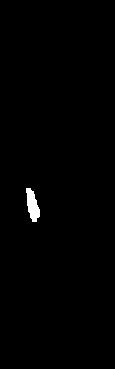

In [ ]:
clahe_image, binary_image = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

roi_mask = np.zeros_like(image, dtype=np.uint8)

# identifying ROI contour by largest area
roi_contour_index = np.argmax([cv2.contourArea(cnt) for cnt in contours])
cv2.drawContours(roi_mask, contours, roi_contour_index, (255), thickness=cv2.FILLED)
ret, roi_mask_binary = cv2.threshold(roi_mask, 1, 255, cv2.THRESH_BINARY)
cv2_imshow(roi_mask_binary)

In [ ]:
area = np.count_nonzero(roi_mask_binary)

print(f"area of ROI = {area} pixels")

area of ROI = 298 pixels
